# 22 - 去偏/正交机器学习

我们接下来要介绍的这种元学习器其实早在“元学习器”这个称谓出现之前就被提出。据我所知，它源自一篇优秀的 2016 年论文，这篇论文为因果推断文献开辟了一个丰饶的领域。这篇论文名为《双重机器学习用于处理和因果参数》（Double Machine Learning for Treatment and Causal Parameters），作者阵容强大：Victor Chernozhukov、Denis Chetverikov、Mert Demirer、Esther Duflo（顺便说一下，她与 Abhijit Banerjee 和 Michael Kremer 因“通过实验方法缓解全球贫困”共同获得了 2019 年诺贝尔经济学奖）、Christian Hansen、Whitney Newey 和 James Robins。难怪这篇论文如此精彩，我甚至借用了 Paul Goldsmith-Pinkham 的创意，将作者们画成复仇者联盟，以示敬意。

![img](./images/22/avengers.png)

唯一的问题是，这篇论文非常难读（这很正常，因为它是计量经济学论文）。既然这本书旨在让因果推断走向大众，我们就来尝试让去偏/正交机器学习的思想变得直观易懂。

为什么值得单独用一章来讲述它，而不是把它和其他元学习器放在一起？吸引我注意的一点是这种去偏/正交机器学习的理论基础非常充分。我们之前见到的 T-learner、S-learner 和 X-learner 都有点类似巧妙的小技巧。我们可以给出它们为何有效的直观解释，但它们似乎不够一般。而去偏/正交机器学习则提供了一个既直观又严谨的通用框架，而且适用于连续和离散两类处理，这是 T-learner 和 X-learner 无法做到的。更不用说这些论文对这种估计量的渐近性质做了极好的分析。因此，让我们开始吧。

作为激励例子，我们再次回到冰淇淋销售数据。提醒一下，我们试图找到价格对销售影响的异质性。我们的测试集中的价格是随机分配的，但训练数据中的价格只是观测到的，可能带有偏差。

In [99]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast
import statsmodels.formula.api as smf
from matplotlib import style
style.use("ggplot")

In [100]:
test = pd.read_csv("./data/ice_cream_sales_rnd.csv")
train = pd.read_csv("./data/ice_cream_sales.csv")
train.head()

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


<Axes: xlabel='price', ylabel='sales'>

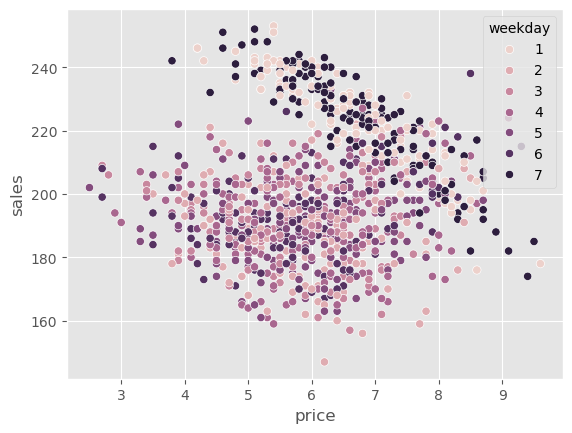

In [102]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="price", y="sales", hue="weekday")

一个明显的偏差来源很容易看出来。正如图中所示，周末（星期 1 和 7）的价格要高得多，但我们还可能有其他混杂因素，如温度和成本。因此，如果我们想做任何因果推断，就需要校正这种偏差。

## 对骚扰参数使用机器学习

一种尝试消除这种偏差的方法是使用线性模型来估计价格对销售的处理效应，同时控制混杂变量。

$$
Sales_i = \alpha + \tau \; price_i + \beta_1 \; temp_i + \beta_2 \; cost_i + \pmb{\beta_3} \; Weekday_i + e_i
$$

其中 $\pmb{\beta_3}$ 是与每个工作日虚拟变量相关联的参数向量。

注意我们只对参数 $\tau$ 感兴趣，因为那是我们的处理效应。其他参数称为干扰（nuisance）参数，因为我们并不关心它们。不过，事实证明，即使我们不关心它们，也必须正确估计它们，否则处理效应就会偏离真实值，这真是有点烦人。

例如，从直觉上看，`temp` 与销售之间的关系可能不是线性的。随着气温升高，人们会去海滩并购买更多冰淇淋，销售额会上升。但在某个温度之后太热了，人们选择呆在家里，这时销售会下降。`temp` 与销售的关系可能先上升后下降，也就是说，上面的模型可能是错的，它应该包括一个二次项：

$$
Sales_i = \alpha + \tau \; price_i + \beta_1 \; temp_i + \beta_2 \; temp_i^2 + \beta_3 \; cost_i + \pmb{\beta_4} \; Weekday_i + e_i
$$

![img](./images/22/non-linear.png)

思考如何为干扰参数建模已经很枯燥了，何况如果我们有几十甚至上百个协变量？在现代数据集中，这很常见。我们能做什么呢？答案在于计量经济学中最酷的定理之一。

### Frisch-Waugh-Lovell 定理

Frisch、Waugh 和 Lovell 是 20 世纪的计量经济学家，他们发现了线性回归中一个非常酷的性质。这对你来说并不陌生，我们在谈到回归残差和固定效应时已经提到过。但由于这个定理是理解正交机器学习的关键，非常值得回顾。

假设你有一个线性回归模型，包含一组特征 $X_1$ 和另一组特征 $X_2$。估计该模型的参数

$
\hat{Y} = \hat{\beta}_1 X_1 + \hat{\beta}_2 X_2
$

其中 $X_1$ 和 $X_2$ 是特征矩阵（每列是一个特征，每行是一条观测），$\hat{\beta}_1$ 和 $\hat{\beta}_2$ 是行向量。你可以通过以下步骤得到与直接回归相同的 $\hat{\beta}_1$：

1. 用第二组特征回归结果 $y$ 得到 $\hat{y}^* = \hat{\gamma}_1 X_2$。
2. 用第二组特征回归第一组特征 $X_1$ 得到 $\hat{X}_1 = \hat{\gamma}_2 X_2$。
3. 取残差 $\tilde{X}_1 = X_1 - \hat{X}_1$ 和 $\tilde{y}_1 = y - \hat{y}^*$。
4. 用特征残差回归结果残差 $\tilde{y}_1 = \hat{\beta}_1 \, \tilde{X}_1$。

这太酷了。这里有一个通用的表示，但注意其中一组特征可以只是处理变量。这意味着你可以单独估计所有干扰参数。先用特征回归结果得到结果残差，再用特征回归处理得到处理残差，最后用处理残差回归结果残差。这将给出与直接在结果上回归特征和处理得到的估计完全相同的 $\hat{\beta}_1$。

不要只是听我说。任何对因果推断感兴趣的人都应该至少做一次 FWL 定理练习。下面的例子中，我们首先估计协变量对结果（销售）和处理（价格）的影响，然后用 FWL 步骤估计处理效应。

In [105]:
my = smf.ols("sales~temp+C(weekday)+cost", data=train).fit()
mt = smf.ols("price~temp+C(weekday)+cost", data=train).fit()

然后，利用这些残差，我们估计价格对销售的平均处理效应（ATE）。

In [108]:
smf.ols("sales_res~price_res", 
        data=train.assign(sales_res=my.resid, # sales residuals
                          price_res=mt.resid) # price residuals
       ).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4.843e-13,0.111,-4.38e-12,1.000,-0.217,0.217
price_res,-4.0004,0.110,-36.428,0.000,-4.216,-3.785


我们估计出的 ATE 为 -4，这意味着价格每提高一个单位，销售将减少 4 单位。

现在，让我们在同一个模型中同时包含处理和协变量，估计同一个参数。

In [111]:
smf.ols("sales~price+temp+C(weekday)+cost", data=train).fit().params["price"]

-4.000429145475441

如你所见，得到的数字完全一致！这说明，无论是一次性估计处理效应，还是按照 FWL 步骤分开估计，从数学上来说是相同的。

换句话说，处理效应可以通过**残差回归**来得到，其中我们先将 $Y$ 对 $X$ 回归得到残差，再将残差回归于将 $T$ 对 $X$ 回归得到的残差。用符号表示为：

$
(Y - (Y \sim X)) \sim (T - (T \sim X))
$

这本质上是在下面的模型中估计因果参数 $\tau$：

$
Y_i - E[Y_i | X_i] = \tau \cdot (T_i - E[T_i | X_i]) + \epsilon_i
$

FWL 的妙处在于，它让我们可以将因果参数的估计过程与干扰参数的估计过程分离。但我们还没有回答最初的问题：怎样避免为干扰参数指定正确的函数形式？换句话说，如何只关注因果参数，而不必担心干扰参数？这正是机器学习发挥作用的地方。

### 加强版 FWL：Double/Debiased ML

Double/Debiased ML 可以看作是 FWL 定理的升级版。思路很简单：在构建结果和处理残差时使用机器学习模型：

$
Y_i - \hat{M}_y(X_i) = \tau \cdot (T_i - \hat{M}_t(X_i)) + \epsilon_i
$

其中 $\hat{M}_y(X_i)$ 估计 $E[Y|X]$，$\hat{M}_t(X_i)$ 估计 $E[T|X]$。由于 ML 模型非常灵活，它们可以捕捉 $Y$ 与 $T$ 对 $X$ 之间的复杂关系，同时保持 FWL 式的正交化。这意味着我们不必对协变量 $X$ 与结果 $Y$ 或处理之间的关系作任何参数假设，就能得到正确的处理效应。在不存在未观测混杂的情况下，我们可以通过以下正交化步骤恢复 ATE：

1. 使用灵活的 ML 回归模型 $M_y$ 用特征 $X$ 预测结果 $Y$。
2. 使用灵活的 ML 回归模型 $M_t$ 用特征 $X$ 预测处理 $T$。
3. 计算残差 $\tilde{Y} = Y - M_y(X)$ 和 $\tilde{T} = T - M_t(X)$。
4. 将结果残差回归于处理残差：$\tilde{Y} = \alpha + \tau \tilde{T}$。

这里的 $\tau$ 就是 ATE，可以用普通最小二乘等方法估计。

利用机器学习的强大之处在于灵活性，可以在干扰关系中捕捉复杂函数形式。但这种灵活性也带来麻烦，因为模型可能会过拟合。这就是我们需要引入交叉预测和折外残差的原因：我们将数据分成 K 份，在 K-1 份上训练模型，在剩下一份上预测残差，这样即便模型过拟合，也不会把残差压到零。最后合并所有部分的预测，用这些残差来估计最终的因果模型 $\tilde{Y} = \alpha + \tau \tilde{T}$。

接下来我们通过一步一步的实现来展示 Double/Debiased ML，在实践中解释每一步的作用。我们首先用 ML 模型估计干扰关系，从处理模型 $M_t$ 开始；我们将用 LGBM 模型通过 `temp`、`weekday` 和 `cost` 预测价格，这些预测将用 `sklearn` 的 `cross_val_predict` 函数得到折外预测。我还为可视化添加了平均值 $\hat{\mu_t}$ 到残差中。

In [114]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3, force_col_wise=True, verbose=-1)

train_pred = train.assign(price_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5)
                          + train[T].mean()) # add mu_t for visualization. 

注意我将 $M_t$ 称为去偏模型，这是因为在 Double/Debias ML 中，它的作用是为处理去偏。残差 $\tilde{T} = T - M_t(X)$ 可以被看作是处理的一个版本，其中所有来自 $X$ 的混杂偏差都被模型剔除了。换句话说，$\tilde{T}$ 与 $X$ 正交。直观地讲，$\tilde{T}$ 不再能用 $X$ 解释，因为它已经被解释掉了。

为了看这一点，我们可以绘制与之前相同的图，但将价格替换为价格残差。还记得之前周末价格更高吗？现在这种偏差消失了。所有工作日的价格残差分布都相同。

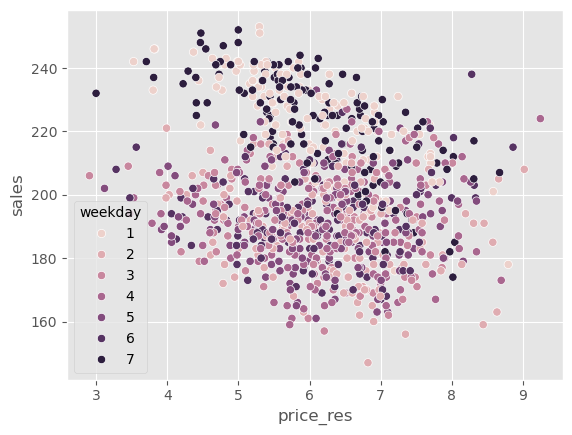

In [117]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales", hue="weekday");

$M_t$ 的作用是对处理去偏，那么 $M_y$ 的作用是什么呢？它的作用是消除 $Y$ 中的方差，因此我称之为降噪模型（denoising model）。直观地说，$M_y$ 创建了一个结果的版本，其中来自 $X$ 的所有方差都被解释掉了。结果是，在 $\tilde{Y}$ 中做因果估计更容易。由于噪声更少，因果关系更容易看清。

In [120]:
denoise_m = LGBMRegressor(max_depth=3, force_col_wise=True, verbose=-1)

train_pred = train_pred.assign(sales_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5)
                               + train[y].mean())

如果我们绘制与之前相同的图，但将销售额替换为销售残差，可以看到 $Y$ 的方差比之前小得多。

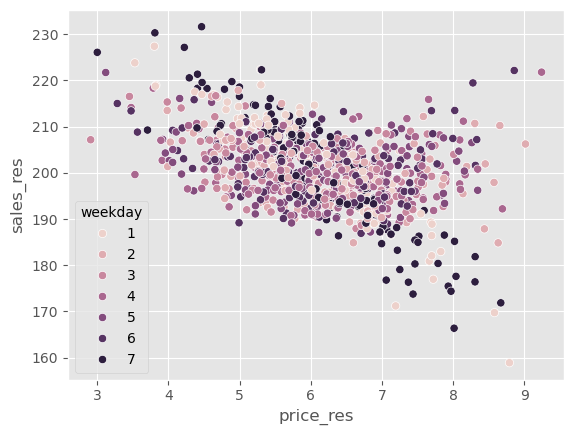

In [123]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales_res", hue="weekday");

现在很容易看出价格与销售之间的负相关关系。

最后，为了估计这种因果关系，我们可以对残差运行回归。

In [126]:
final_model = smf.ols(formula='sales_res ~ price_res', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,224.5586,0.443,506.469,0.000,223.689,225.428
price_res,-3.9228,0.071,-54.962,0.000,-4.063,-3.783


正如我们所看到的，当我们使用正交化后的销售和价格时，我们可以非常确信价格和销售之间是负相关的，这很合乎情理。随着价格上涨，冰淇淋的需求应该下降。

但如果看未经残差处理的原始价格与销售关系，由于偏差，我们会发现它们呈正相关。这是因为商家在预期销售高峰时提高价格。

In [129]:
final_model = smf.ols(formula='sales ~ price', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.9679,1.013,190.414,0.000,190.981,194.954
price,1.2294,0.162,7.575,0.000,0.911,1.547


### 使用 Double-ML 估计 CATE

到目前为止，我们已经看到 Double/Debiased ML 使我们能够专注于估计平均处理效应 (ATE)。它同样可以用来估计处理效应异质性，即条件平均处理效应 (CATE)。本质上，我们现在认为因果参数 $\tau$ 会随着单位的协变量而变化。

$
Y_i - {M}_y(X_i)
= \tau(X_i) \cdot (T_i - {M}_t(X_i)) + \epsilon_i
$

为了估计这个模型，我们将使用同样的价格和销售残差，但现在我们将价格残差与其他协变量相互作用。然后，我们可以拟合一个线性的 CATE 模型

$
\tilde{Y}_i = \alpha + \beta_1 \tilde{T}_i + \pmb{\beta}_2 \pmb{X}_i \tilde{T}_i + \epsilon_i
$

估计完该模型后，为了预测 CATE，我们将使用随机的测试集。由于最终模型是线性的，我们可以机械地计算 CATE：

$
\hat{\mu}(\partial Sales_i, X_i) = M(Price=1, X_i) - M(Price=0, X_i)
$

其中 $M$ 是我们的最终线性模型。

In [132]:
final_model_cate = smf.ols(formula='sales_res ~ price_res * (temp + C(weekday) + cost)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(price_res=1))
                        - final_model_cate.predict(test.assign(price_res=0)))

为了检验该模型在区分高价格敏感性和低价格敏感性单位方面表现如何，我们将使用累积弹性曲线。

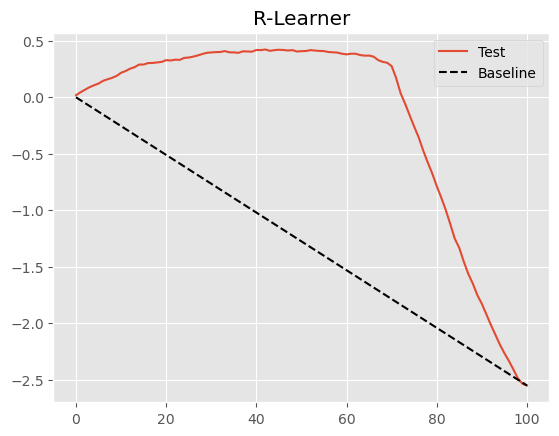

In [135]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

使用最终线性模型的 Double/Debiased ML 程序已经非常不错，如上图所示。但也许我们能做得更好。事实上，这是一种非常通用的程序，我们可以像元学习器一样理解它。Nie 和 Wager 将其称为 R-Learner，以纪念 Robinson (1988) 的工作，并强调残差化的重要性。

这种推广来自于认识到 Double/Debiased ML 程序定义了一个新的损失函数，我们可以用任何方法来最小化它。接下来，我们将看到如何以类似于目标变换方法或 F-learner 的方式实现这一点。

## 非参数 Double/Debiased ML

Double-ML 的好处在于它让我们摆脱了在因果模型中学习干扰参数的烦恼。这样，我们可以将所有注意力集中在学习感兴趣的因果参数上，无论是 ATE 还是 CATE。然而，在上述设定下，我们在 ML 残差化之后仍然使用线性模型作为最终的因果模型。在我们的例子中，这意味着我们假设价格对销售的影响是线性的。这在价格变化范围较小时可能还好，但微观经济理论告诉我们情况不一定如此。例如，在低价区间，价格每升高一个单位需求可能下降 2 单位；而在高价区间，价格每升高一个单位需求可能只下降 1 单位。这显然不是线性关系。

我们可以利用微观经济理论来推测结果对处理的函数形式，但也许我们可以把这一任务交给机器学习模型。换句话说，让机器自己学习那种复杂的函数形式。事实证明，只要对原来的 Double/Debiased ML 算法做些调整，这完全可行。

首先，与之前完全相同，我们用 ML 模型和交叉预测对处理和结果进行正交化。

In [138]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3, force_col_wise=True, verbose=-1)
denoise_m = LGBMRegressor(max_depth=3, force_col_wise=True, verbose=-1)

train_pred = train.assign(price_res =  train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5),
                          sales_res =  train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5))

到目前为止还没有什么不同之处。现在事情开始有趣了。回想一下 Double/Debiased-ML 将数据建模为：

$
Y_i = \hat{M}_y(X_i) + \tau(X_i)\big(T_i - \hat{M}_t(X_i)\big) + \hat{\epsilon}_i
$

其中 $\hat{M}_y$ 和 $\hat{M}_t$ 分别是用特征预测结果和处理的模型。若重新排列上述表达式，可以隔离误差项：

$
\hat{\epsilon}_i = \big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i)\big(T_i - \hat{M}_t(X_i)\big)
$

这非常棒，因为我们可以将其称为**因果损失函数**。这意味着，如果我们最小化该损失的平方，我们将估计 $\tau(X_i)$ 的期望，即 CATE。

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum_{i=1}^n \Big( (Y_i - \hat{M}_y(X_i)) - \tau(X_i)(T_i - \hat{M}_t(X_i)) \Big)^2
$

这个损失也称为 **R-Loss**，这是 R-learner 最小化的目标。如何最小化它呢？有多种方法，这里我们介绍最简单的一种。为了简化符号，我们用残差化后的处理和结果来重写上述损失函数：

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum_{i=1}^n \big( \tilde{Y}_i - \tau(X_i) \tilde{T}_i \big)^2
$

通过代数变换，可以把 $\tilde{T}_i$ 提到括号外，将 $\tau(X_i)$ 单独放在括号内部：

$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum_{i=1}^n \tilde{T}_i^2 \left(\frac{\tilde{Y}_i}{\tilde{T}_i} - \tau(X_i)\right)^2
$$

最小化上述损失等价于最小化括号内的表达式，同时用 $\tilde{T}_i^2$ 作为权重。这一技巧称为加权技巧（weight trick），用以构建非参数因果损失。注意这与我们之前看到的目标变换思想非常相似——确实，这也是一种目标变换，但加入了权重。

总结一下，在得到了干扰模型和残差化的处理与结果后，我们将：
1. 构建权重 $\tilde{T}_i^2$；
2. 构建目标 $\tilde{Y}_i / \tilde{T}_i$；
3. 使用任意预测方法在权重下预测目标 (2)。

下面就是对应的代码。

In [141]:
model_final = LGBMRegressor(max_depth=3, force_col_wise=True, verbose=-1)
 
# create the weights
w = train_pred["price_res"] ** 2 
 
# create the transformed target
y_star = (train_pred["sales_res"] / train_pred["price_res"])
 
# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train[X], y=y_star, sample_weight=w);

The above ML model, even though it is an off-the-shelf predictive model, is estimating the CATE. That's the power of the non-parametric Double-ML. Before, we were using a linear regression as the final model for the CATE estimation. Now, since we defined a generic loss, we can use any predictive model at our disposal as the final model. 
 
Let's now use the test set to compare this non-parametric version with the linear version we had before. 
 
First, we estimate the individual treatment effect.

In [144]:
cate_test_non_param = test.assign(cate=model_final.predict(test[X]))

Next, we can plot the non-parametric cumulative elasticity curve side by side with the one we got from the parametric  (linear) version of Double/Orthogonal-ML.

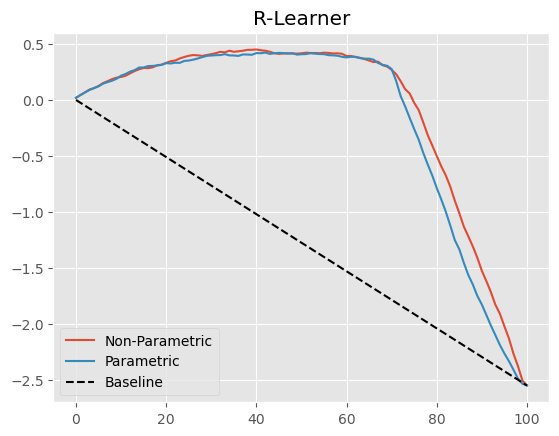

In [147]:
gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

这里改进不大，但多少有点进步。此外，不必事先指定处理函数的形式本身就是一个巨大的优势。

### 什么是“非参数”？

在继续之前，我想强调一个常见的误解。当我们想到用非参数 Double-ML 模型来估计 CATE 时，好像意味着我们会得到非线性的处理效应。比如，假设一个非常简单的数据生成过程（DGP），其中折扣以平方根形式非线性地影响销售：

$
Sales_i = 20 + 10\sqrt{Discount_i} + e_i
$

处理效应是销售函数对处理的导数：

$
\dfrac{\partial Sales_i}{\partial Discount_i} = \frac{10}{2\sqrt{Discount_i}}
$

可以看到，处理效应并不是线性的。随着处理增加，效应实际上减弱。这对这个 DGP 很合理：一开始少量折扣会显著增加销售，但折扣给多了之后，额外的折扣对销售的影响会越来越小，因为人们不会无限购买，所以折扣只有在他们尚未满足之前才有效。

那么问题来了，非参数 ML 能否捕捉这种饱和行为的处理效应？能否从小的折扣水平外推得知，如果折扣更高，处理效应会更低？答案是……某种程度上可以。为了更好地理解这一点，我们生成与上述 DGP 类似的数据。

In [150]:
np.random.seed(321)
n=5000
discount = np.random.gamma(2,10, n).reshape(-1,1)
discount.sort(axis=0) # for better ploting
sales = np.random.normal(20+10*np.sqrt(discount), 1)

如果我们绘制这个数据生成过程，可以看到变量之间的平方根关系。

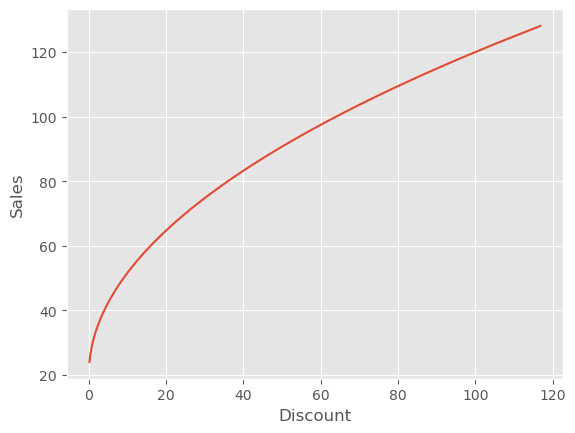

In [153]:
plt.plot(discount, 20 + 10*np.sqrt(discount))
plt.ylabel("Sales")
plt.xlabel("Discount");

现在，让我们把非参数 Double/Debias ML 应用于这份数据。

In [156]:
debias_m = LGBMRegressor(max_depth=3, force_col_wise=True, verbose=-1)
denoise_m = LGBMRegressor(max_depth=3, force_col_wise=True, verbose=-1)

# orthogonalising step
discount_res =  discount.ravel() - cross_val_predict(debias_m, np.ones(discount.shape), discount.ravel(), cv=5)
sales_res =  sales.ravel() - cross_val_predict(denoise_m, np.ones(sales.shape), sales.ravel(), cv=5)

# final, non parametric causal model
non_param = LGBMRegressor(max_depth=3, force_col_wise=True, verbose=-1)
w = discount_res ** 2 
y_star = sales_res / discount_res

non_param.fit(X=discount_res.reshape(-1,1), y=y_star.ravel(), sample_weight=w.ravel());

利用上述模型，我们可以得到 CATE 估计。问题在于，CATE 不是线性的；随着处理增加，CATE 应当下降。我们想知道非参数模型是否能够捕捉这种非线性。

要正确回答这个问题，让我们回忆 Double/Debiased ML 对数据生成过程的基本假设。这些假设可由之前的等式表示：

$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$

用语言来说，这意味着残差化后的结果等于残差化后的处理乘以条件处理效应。这说明**处理对结果的影响是线性的**。这里没有非线性。该模型暗示，当我们把处理从 1 增加到 10，或从 100 增加到 110，结果都会增加一个固定的量 $\tau(X_i)$，只是简单的乘法。

那这是否意味着非参数模型不能捕捉处理效应的非线性？也不是……实际上，Double/ML 所做的是**寻找非线性 CATE 的局部线性近似**。换句话说，它找到结果相对于处理在某个处理水平处的导数。这等价于找到在处理点附近与结果函数相切的直线的斜率。

![img](./images/22/linear-aprox.png)

这意味着，非参数 Double-ML 确实能够意识到随着处理增加，处理效应会降低，但它提供的是局部斜率而不是全局非线性函数。

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/var/folders/lf/pj0tjh091t56trz0l1z6m8kc0000gn/T/ipykernel_47930/1491753946.py:12: SyntaxWarning: invalid escape sequence '\h'
  plt.scatter(discount, cate, label="$\hat{\\tau}(x)$", c="C4")
/var/folders/lf/pj0tjh091t56trz0l1z6m8kc0000gn/T/ipykernel_47930/1491753946.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.title("CATE ($\partial$Sales) by Discount")


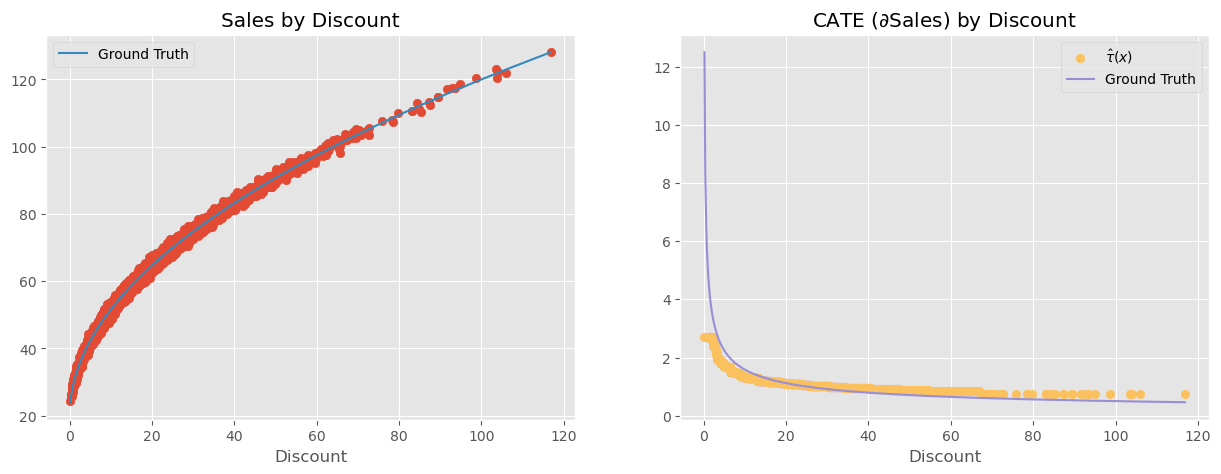

In [159]:
cate = non_param.predict(X=discount)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(discount, sales)
plt.plot(discount, 20 + 10*np.sqrt(discount), label="Ground Truth", c="C1")
plt.title("Sales by Discount")
plt.xlabel("Discount")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(discount, cate, label="$\hat{\\tau}(x)$", c="C4")
plt.plot(discount, 5/np.sqrt(discount), label="Ground Truth", c="C2")
plt.title("CATE ($\partial$Sales) by Discount")
plt.xlabel("Discount")
plt.legend();

这听起来像是技术细节，但有非常实际的后果。例如，假设在上述例子中你发现某位客户的处理效应为 2，也就是说如果将折扣提高 1 个单位，该客户的销售额会增加 2 个单位。你可能会想：“太好了！我要给这个人更多折扣！毕竟每 1 单位折扣能带来 2 单位销售。”然而这是错误的结论。处理效应为 2 只是在那一折扣水平下的局部结果。一旦提高折扣，效应就会下降。例如，这个假想客户只有 5 的折扣，因此处理效应很高。如果你看到这个巨大的处理效应并用它来证明应该给这个客户 20 的折扣，那么当你这么做时，效应可能从 2 降至 0.5。以 2 的处理效应计算看似合理的 20 的折扣，在处理效应只有 0.5 时可能不再盈利。

这意味着在将非线性的处理效应外推到新的处理水平时必须格外小心。否则你可能做出非常不划算的决定。换句话说，当处理效应不是线性时，即使是非参数 Double/Debiased-ML 也**难以进行反事实结果预测**。它会试图将低处理水平下的处理效应线性外推到高处理水平，反之亦然，由于非线性，这种外推可能会偏离实际。

为解决这个问题，还有一个最后的思路……

In [162]:
from sklearn.model_selection import KFold

def cv_estimate(train_data, n_splits, model, model_params, X, y):
    cv = KFold(n_splits=n_splits)    
    models = []
    cv_pred = pd.Series(np.nan, index=train_data.index)
    for train, test in cv.split(train_data):
        m = model(**model_params)
        m.fit(train_data[X].iloc[train], train_data[y].iloc[train])
        cv_pred.iloc[test] = m.predict(train_data[X].iloc[test])
        models += [m]
    
    return cv_pred, models


现在我们有了自己的交叉预测函数，并且得到了模型，我们可以继续执行正交化步骤。

In [165]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3, force_col_wise=True, verbose=-1)
denoise_m = LGBMRegressor(max_depth=3, force_col_wise=True, verbose=-1)

y_hat, models_y = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3, force_col_wise=True, verbose=-1), X, y)
t_hat, models_t = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3, force_col_wise=True, verbose=-1), X, T)

y_res = train[y] - y_hat
t_res = train[T] - t_hat

正交化之后，我们将 $\tilde{T}$ 与 $X$ 一起输入机器学习模型，用它来预测 $\tilde{Y}$。这里我使用的是 LGBM 模型，但你可以选择任何机器学习模型。LGBM 的一个好处是可以设置单调约束。基于我们对价格的了解，销售应随着价格的上升而下降。我们可以将这一点纳入约束，让 LGBM 模型在价格上升时**不要增加**其预测值。

In [168]:
# -1 on price saying that the predictions should not increase as price increases
monotone_constraints = [-1 if col == T else 0 for col in X+[T]]
 
model_final = LGBMRegressor(max_depth=3, monotone_constraints=monotone_constraints, force_col_wise=True, verbose=-1)
model_final = model_final.fit(X=train[X].assign(**{T: t_res}), y=y_res)

现在事情有点奇怪。如果仔细想想，这个最终的 ML 模型实际上是在估计以下的 $\tau$ 函数：

$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i) + e_i
$

但从这个函数中并没有明确的方式提取处理效应。因此，我们不再尝试直接提取处理效应，而是像前面图示那样输入反事实预测。我们将为每个单位模拟不同的价格水平，并使用 Double-ML 模型预测在这些不同价格水平下的销售量。

为此，我们将 1) 将测试集与包含所有模拟价格的价格表进行笛卡尔连接，得到如下结果……

In [171]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 10, 9))), on="jk")
             .drop(columns=["jk"]))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price
0,0,25.8,1,0.3,7,230,3.000
1,0,25.8,1,0.3,7,230,3.875
2,0,25.8,1,0.3,7,230,4.750
3,0,25.8,1,0.3,7,230,5.625
4,0,25.8,1,0.3,7,230,6.500
5,0,25.8,1,0.3,7,230,7.375
6,0,25.8,1,0.3,7,230,8.250
7,0,25.8,1,0.3,7,230,9.125
8,0,25.8,1,0.3,7,230,10.000


注意我们只展示了索引为 1 的那一天，即单个单位。在那一天，该单位的实际价格是 7。但我们模拟了从 3 到 10 的不同反事实价格。现在，我们将把所有这些反事实价格输入因果模型，该模型会根据模拟的价格给出反事实销售预测。

由于我们的模型形式为：

$
\widehat{Price_i} = \hat{\tau}(X_i, \tilde{T}_i)
$

在进行反事实预测之前，我们需要得到 $\tilde{T}_i$，即价格残差。我们将首先用所有的处理模型进行预测（记住训练时我们用了 5 折交叉预测），然后将五个模型的预测平均为一个单一预测，最后用这个集成模型的预测减去我们之前生成的反事实价格，以获得残差。

In [174]:
def ensamble_pred(df, models, X):
    return np.mean([m.predict(df[X]) for m in models], axis=0)

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test}))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,24.302849
1,0,25.8,1,0.3,7,230,3.875,20.862833
2,0,25.8,1,0.3,7,230,4.750,16.093630
3,0,25.8,1,0.3,7,230,5.625,6.274595
4,0,25.8,1,0.3,7,230,6.500,-1.624625
5,0,25.8,1,0.3,7,230,7.375,-10.939867
6,0,25.8,1,0.3,7,230,8.250,-21.655858
7,0,25.8,1,0.3,7,230,9.125,-25.319174
8,0,25.8,1,0.3,7,230,10.000,-25.319174


可以看到，我们现在对每个模拟价格都有销售预测。价格越低，销售越高。有趣的是，这些预测的水平偏离实际，例如从约 24 到约 -24。这是因为模型预测的是残差化后的结果，其均值约为零。如果你只想得到销售曲线的斜率，即价格的处理效应，这没有问题。另外，如果你想修正预测水平，只需将降噪模型 $M_y$ 的预测加回来即可。

In [177]:
y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = (y_hat_test + 
                          model_final.predict(X=pred_test[X].assign(**{T: t_res_test})))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,254.208352
1,0,25.8,1,0.3,7,230,3.875,250.768336
2,0,25.8,1,0.3,7,230,4.750,245.999133
3,0,25.8,1,0.3,7,230,5.625,236.180099
4,0,25.8,1,0.3,7,230,6.500,228.280878
5,0,25.8,1,0.3,7,230,7.375,218.965636
6,0,25.8,1,0.3,7,230,8.250,208.249645
7,0,25.8,1,0.3,7,230,9.125,204.586329
8,0,25.8,1,0.3,7,230,10.000,204.586329


我们还可以绘制单位级别的销售曲线。让我们抽样十个单位，看看它们在不同价格下的表现。

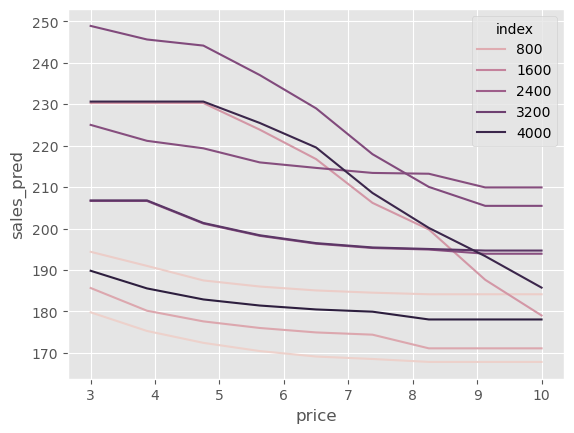

In [180]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=pred_test.query("index in @sample_ids"),
             x="price", y="sales_pred", hue="index");

有趣的是，一些单位对价格上涨非常敏感。在某些情况下，当价格从 3 增加到 10 时，我们预测销售会从 250 降至将近 200。另一方面，一些单位的价格弹性非常小：当价格从 3 增至 10 时，我们预计销售仅从大约 195 降到大约 185。

这些价格敏感性的差异很难直接看出，所以我喜欢做的是让所有曲线从同一个起点（此处为平均销售量）开始。这能让我们更容易看到一些单位在价格提高时销售急剧下降，而其他单位下降不那么明显。

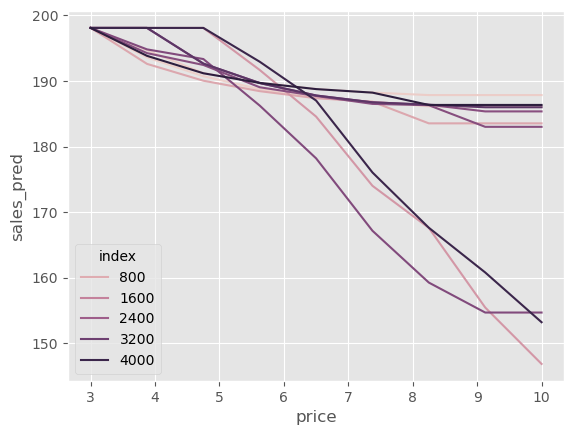

In [183]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

### 可能需要更多计量经济学！

![img](./images/22/more-metrics.png)

我想以一则提醒结束这一“非科学”的 Double-ML 部分。我称这种方法为非科学并非无故。它有点像一种获取非线性反事实预测的巧妙办法。既然是个巧妙的方法，我觉得有必要谈谈它的潜在弊端。

首先，它有所有机器学习方法在因果推断中未经调整时面临的同样问题：偏差。由于最终模型是一个正则化的 ML 模型，这种正则化可能会把因果估计偏向零。

第二个问题与您选择的 ML 算法有关。这里我们选择的是提升树。树不擅长生成平滑的预测，因此预测曲线可能会出现不连续的跳变，这在上面的图中可以看到：某些地方出现阶梯状行为。此外，树不擅长外推，因此该模型可能会对训练集中未出现过的价格输出奇怪的预测值。

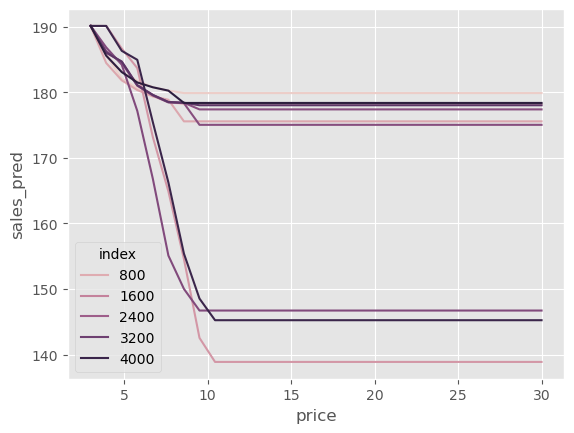

In [186]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 30, 30))), on="jk")
             .drop(columns=["jk"]))

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test})) + y_hat_test

np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

总结来说，这种方法高度依赖于最终的 ML 模型。如果正则化太强，因果估计将会偏向零；使用某个具体的 ML 算法，也会将其所有局限性带入最终的反事实预测。尽管如此，如果你认为这种方法值得尝试，不妨一试！只要别忘了我在这里指出的缺点。

## 关键观点

Double/Debiased/Orthogonal ML 提供了一种估计干扰参数的方法，使我们能够将注意力集中在感兴趣的因果参数上。它首先采用两步正交化过程：

1. 拟合一个模型 $M_t(X)$ 用协变量 $X$ 预测处理 $T$，并获得折外残差 $\tilde{t} = t - M_t(X)$。我们称之为去偏模型，因为残差 $\tilde{t}$ 按定义与用于构建它的特征正交。
2. 拟合一个模型 $M_y(X)$ 用协变量 $X$ 预测结果 $Y$，并获得折外残差 $\tilde{y} = y - M_y(X)$。我们称之为降噪模型，因为残差 $\tilde{y}$ 可以看作是消除了特征方差的结果版本。

一旦得到了这些残差，在不存在未观察混杂的情况下，我们可以将 $\tilde{y}$ 回归于 $\tilde{t}$ 得到 ATE 的线性近似。我们也可以将 $\tilde{t}$ 与协变量相互作用来估计 CATE，或使用加权技巧让任何通用 ML 模型成为最终的 CATE 模型。

![img](./images/22/diagram.png)

最后，我认为正交化步骤是一种促进因果学习的通用工具。本着这种精神，我们尝试将处理和结果残差输入类似 S-learner 的 ML 算法。这样，我们便可以从模拟的处理中获取反事实预测。的确，正交机器学习在许多因果推断应用中充当预处理步骤。

## 参考说明

本章内容主要基于作者个人的经验总结，许多观点和方法源自实践中的体会。因此，无法提供严格意义上的学术参考文献。与正规科研工作不同，这些内容没有经过系统性的学术审查，也未经过同行评议与理论论证。读者或许会注意到，本文更多讨论的是“实践中有效的方法”，而非详细阐述其背后的理论基础。这种方法可以被视为“来自一线的经验科学”（a sort of science from the streets）。尽管如此，既然这些内容已公开发布，也非常欢迎批评与反馈——如果读者发现其中有明显错误或不妥之处，欢迎提出 issue，作者会尽力回应。

撰写本章时，作者参考了 Chernozhukov 等 (2016) 《Double/Debiased Machine Learning for Treatment and Causal Parameters》、D. Foster 和 V. Syrgkanis (2019) 《Orthogonal Statistical Learning》以及 *econml* 库的文档。正交 ML 近期备受关注，因此有许多其他参考文献。例如，Nie 和 Wager (2020) 的草稿中对 R-loss 进行了讨论，Athey 等 (2019) 在因果决策树的背景下讨论了它，Chernozhukov 及其合作者还有许多后续论文进一步发展了该主题。

另外，作者从 [Pedro Sant'Anna 的幻灯片](https://pedrohcgs.github.io/files/Callaway_SantAnna_2020_slides.pdf) 中借用了一张图。

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立助理教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。